In [224]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML
pylab.rcParams['figure.figsize'] = (10, 6)

In [226]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Stock Market Clustering

Firstly,we will import our data, which consists of the following two *.csv* files:

* **SP_500_firms.csv:** This file contains all firms currently included in the S&P 500 index.
* **SP_500_close_2015.csv:** This file contains daily stock price data of the firms listed in the previous file for 2015 (without some firms for which data was not available for the entire year).

In [51]:
# Load companies information
firms = pd.read_csv('SP_500_firms.csv', index_col = 0)
# Load companies stock prices
stockPrices = pd.read_csv('SP_500_close_2015.csv', index_col = 0)

In [29]:
firms.iloc[:5, :]

,Name,Sector
Symbol,,
MMM,3M Company,Industrials
ABT,Abbott Laboratories,Health Care
ABBV,AbbVie,Health Care
ACN,Accenture plc,Information Technology
ATVI,Activision Blizzard,Information Technology


In [88]:
stockPrices.iloc[:5, :5]

,MMM,ABT,ABBV,ACN,ATVI
Date,,,,,
2015-01-02,156.678596,43.160459,61.986410,86.129228,19.765196
2015-01-05,153.145069,43.170070,60.819874,84.674997,19.490271
2015-01-06,151.511999,42.679830,60.518833,84.064223,19.126976
2015-01-07,152.610267,43.025880,62.964797,85.828689,18.714587
2015-01-08,156.267949,43.910238,63.623323,87.137495,18.901144


## The main part 

### 1. Stock returns

#### Daily returns

In the first part of the exerice, we calculate the daily returns for all stocks in the data. For this purpose we define the function `stockReturns` which takes as input the dataframe of the stock prices and returns a dataframe with the daily returns of those stocks.

In [117]:
def stockReturns(priceDF):
    
    compTickers = priceDF.columns[0: ]    
    priceMat = priceDF.loc[ : , compTickers].as_matrix()    
    diffMat = (priceMat[1: ] - priceMat[ :-1]) / priceMat[ :-1]
    
    return pd.DataFrame(data = diffMat, index = priceDF.index[1: ], \
                        columns = compTickers)    

In [118]:
dailyReturns = stockReturns(stockPrices)
dailyReturns.iloc[:5, :5]

,MMM,ABT,ABBV,ACN,ATVI
Date,,,,,
2015-01-05,-0.022553,0.000223,-0.018819,-0.016884,-0.013910
2015-01-06,-0.010664,-0.011356,-0.004950,-0.007213,-0.018640
2015-01-07,0.007249,0.008108,0.040417,0.020989,-0.021561
2015-01-08,0.023967,0.020554,0.010459,0.015249,0.009969
2015-01-09,-0.012284,-0.010508,-0.027355,-0.001113,-0.018182


The daily returns of the stocks can be shown in the following figure:

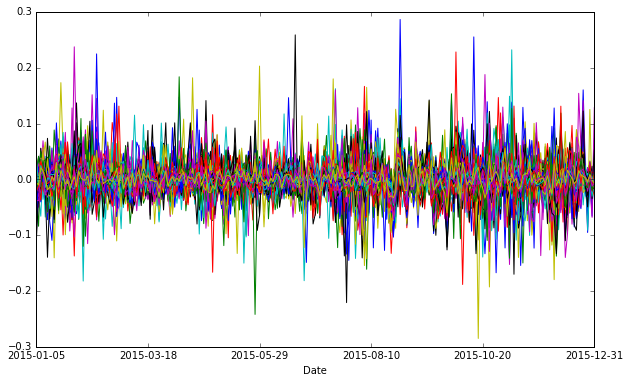

In [212]:
dailyReturns.plot(legend = False);

Next, we will find which companies experienced the **maximum** and **minimum** daily returns, in which days did they experience them and what are potential evidence for those daily returns.

To do so, we will marge the daily returns of all companies in one column and then sort this column in descending order.

In [144]:
dailyReturns['Date'] = dailyReturns.index
# Melt data frame so each row is one price change observation
dailyReturnsMelted = pd.melt(dailyReturns, id_vars = "Date")
dailyReturnsMelted = dailyReturnsMelted.rename(columns = {
    'variable':'Symbol',
    'value':'Price Change'
})
# Sort melted dataframe in descending order of price change
dailyReturnsSorted = dailyReturnsMelted.sort_values(by = 'Price Change', \
                                                    ascending = False)
# Merge on firm data with the symbol as the key
dailyReturnsSorted = dailyReturnsSorted.merge(firms, left_on = 'Symbol', \
                                              right_index = True, how = 'left')

The **maximum** daily returns for 2015 were the following:

In [129]:
dailyReturnsSorted.iloc[:10, :]

,Date,Symbol,Price Change,Name,Sector
49359,2015-08-27,FCX,0.286616,Freeport-McMoran Cp & Gld,Materials
121098,2015-06-22,WMB,0.258999,Williams Cos.,Energy
110887,2015-10-14,TRIP,0.255361,TripAdvisor,Consumer Discretionary
53731,2015-01-29,HAR,0.237600,Harman Int'l Industries,Consumer Discretionary
92330,2015-11-06,QRVO,0.232254,Qorvo,Information Technology
121923,2015-10-02,WYNN,0.228389,Wynn Resorts Ltd,Consumer Discretionary
110718,2015-02-12,TRIP,0.224915,TripAdvisor,Consumer Discretionary
57579,2015-05-29,HUM,0.203128,Humana Inc.,Health Care
64457,2015-10-21,KLAC,0.187895,KLA-Tencor Corp.,Information Technology
86408,2015-04-08,PRGO,0.183899,Perrigo,Health Care


Potential evidence for some of the **maximum** daily returns presented above can be found on the following links:

* Trip advisor: http://fortune.com/2015/10/14/tripadvisor-stock-gain-priceline-deal/
* Williams: http://www.forbes.com/sites/antoinegara/2015/06/22/pipeline-giant-williams-rejects-64-a-share-takeover-bid-from-energy-transfer/#318056c339f8
* Harman: http://investor.harman.com/releasedetail.cfm?releaseid=890984 and http://investor.harman.com/releasedetail.cfm?releaseid=893546 
* Qorvo: http://www.qorvo.com/news/2015/qorvo-announces-proposed-1-billion-senior-notes-offering and http://www.bizjournals.com/triad/news/2015/11/06/qorvo-revenue-rises-in-latest-quarter.html

The **minimum** daily returns for 2015 were the following:

In [130]:
dailyReturnsSorted.iloc[-10:, :]

,Date,Symbol,Price Change,Name,Sector
3720,2015-10-28,AKAM,-0.167306,Akamai Technologies Inc,Information Technology
70243,2015-11-09,MNK,-0.169981,Mallinckrodt Plc,Health Care
82309,2015-12-04,NRG,-0.179581,NRG Energy,Utilities
74667,2015-06-26,MU,-0.181515,Micron Technology,Information Technology
88624,2015-02-04,RL,-0.182169,Polo Ralph Lauren Corp.,Consumer Discretionary
123683,2015-10-07,YUM,-0.188324,Yum! Brands Inc,Consumer Discretionary
103364,2015-10-23,SRCL,-0.192767,Stericycle Inc,Industrials
17458,2015-07-24,BIIB,-0.220802,BIOGEN IDEC Inc.,Health Care
74143,2015-05-27,KORS,-0.241954,Michael Kors Holdings,Consumer Discretionary
92817,2015-10-16,PWR,-0.285006,Quanta Services Inc.,Industrials


Potential evidence for some of the **minimum** daily returns presented above can be found on the following links:

* Akami: http://www.fool.com/investing/general/2015/10/28/why-akamai-technologies-inc-fell-hard-on-wednesday.aspx
* Millinckrodt: http://www.bloomberg.com/news/articles/2015-11-09/mallinckrodt-slumps-on-scrutiny-from-valeant-foe-citron-research
* NRG Energy: http://247wallst.com/infrastructure/2015/12/04/nrg-continues-to-fall-as-ceo-steps-down/
* Micron: http://marketrealist.com/2015/06/microns-share-price-fall-19-june-26/
* Yum: http://www.reuters.com/article/us-yum-brands-china-idUSKCN0S11SZ20151007
* Michael Kors: http://money.cnn.com/2015/05/27/investing/michael-kors-earnings-stock-drop/

#### Yearly returns

Next, we will look at the overall performance of the S&P 500 companies over the whole year. Same as before, we create the function `yearlyStockReturns` which takes as input the dataframe of the stock prices and returns a dataframe with the yearly returns of those stocks.

In [147]:
def yearlyStockReturns(priceDF):
    priceMatrix = priceDF.as_matrix()
    # Calculate the yearly returns:
    # (final price - start price) / start price
    TotalPriceChangeMatrix = (priceMatrix[-1: ] - priceMatrix[ :1]) \
                              / priceMatrix[ :1]
    # Convert the result to a dataframe 
    # with the correct index and column names
    TotalPriceChangeDF = pd.DataFrame(TotalPriceChangeMatrix, \
                                      columns = priceDF.columns)
    # Transpose dataframe
    TotalPriceChangeDFtransposed = TotalPriceChangeDF.transpose()
    TotalPriceChangeDFtransposed.columns = ['Price Change']
    
    return TotalPriceChangeDFtransposed

To find which companies performed overall best and worst over the year we will sort the yearly returns of all companies in descending order.

In [150]:
yearlyReturns = yearlyStockReturns(stockPrices)

# Sort them
yearlyReturnsSorted = yearlyReturns.sort_values(by='Price Change', ascending=False)
# Merge on firm data with the symbol as the key (index in both dfs)
yearlyReturnsSorted = yearlyReturnsSorted.merge(firms, left_index=True, right_index=True, how='left')

The companies that performed **best** over the yeat are the following:

In [152]:
yearlyReturnsSorted.head(10)

,Price Change,Name,Sector
NFLX,1.294549,Netflix Inc.,Information Technology
AMZN,1.190750,Amazon.com Inc,Consumer Discretionary
ATVI,0.942684,Activision Blizzard,Information Technology
AYI,0.676443,Acuity Brands Inc,Industrials
NVDA,0.664514,Nvidia Corporation,Information Technology
GPN,0.600933,Global Payments Inc,Information Technology
HRL,0.559016,Hormel Foods Corp.,Consumer Staples
EXR,0.544469,Extra Space Storage,Financials
VRSN,0.527540,Verisign Inc.,Information Technology
RAI,0.497837,Reynolds American Inc.,Consumer Staples


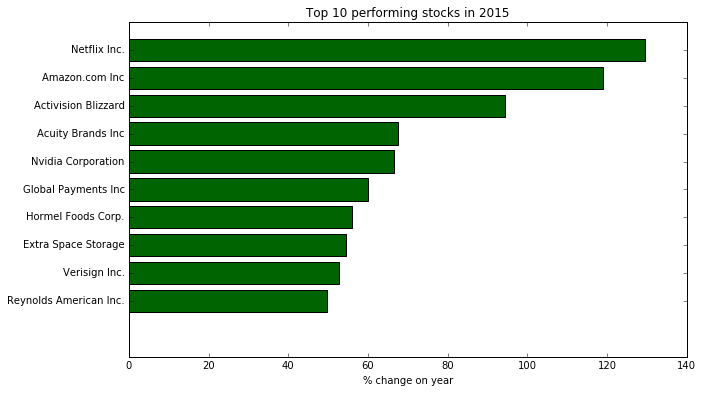

In [225]:
y_pos_top_10 = np.arange(len(yearlyReturnsSorted['Name'][:10])-1,-1,-1)
plt.barh(y_pos_top_10, yearlyReturnsSorted['Price Change'][:10]*100,
         align='center', color='darkgreen')
plt.yticks(y_pos_top_10, yearlyReturnsSorted['Name'][:10])
plt.xlabel("% change on year")
plt.title("Top 10 performing stocks in 2015");

The companies that performed **worst** over the yeat are the following:

In [155]:
yearlyReturnsSorted.tail(10)

,Price Change,Name,Sector
WYNN,-0.516602,Wynn Resorts Ltd,Consumer Discretionary
MUR,-0.538541,Murphy Oil,Energy
MRO,-0.546383,Marathon Oil Corp.,Energy
RRC,-0.553864,Range Resources Corp.,Energy
NRG,-0.559234,NRG Energy,Utilities
MU,-0.592518,Micron Technology,Information Technology
KMI,-0.632032,Kinder Morgan,Energy
FCX,-0.703792,Freeport-McMoran Cp & Gld,Materials
SWN,-0.738314,Southwestern Energy,Energy
CHK,-0.769785,Chesapeake Energy,Energy


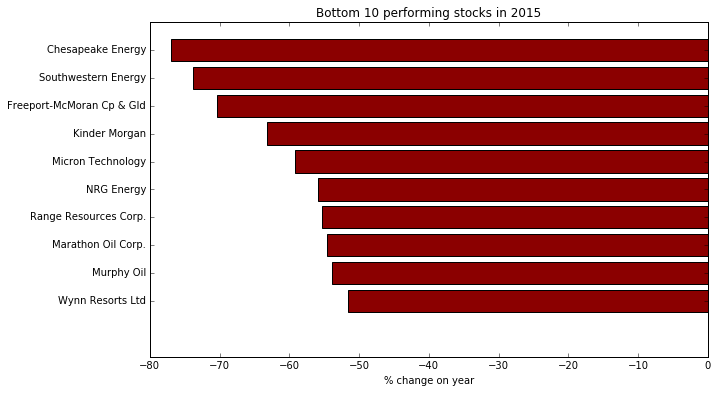

In [209]:
y_pos_top_10 = np.arange(len(yearlyReturnsSorted['Name'][-10:]))
plt.barh(y_pos_top_10, yearlyReturnsSorted['Price Change'][-10:]*100,
         align='center', color='darkred')
plt.yticks(y_pos_top_10, yearlyReturnsSorted['Name'][-10:])
plt.xlabel("% change on year")
plt.title("Bottom 10 performing stocks in 2015");

#### Volatility

Finally, we will try to figure out which companies exhibited **most** and **least** volatility. The volatility of the companies is measured based on the standard deviation of their daily returns over the year. We create the function `volatility` which takes as input a dataframe with the daily returns of the companies and returns a dataframe with the volatility measure of those companies, as defined above.

In [168]:
def volatility(dailyReturns):
    ##calculate sds and change into panda dataframe
    sdPriceChangeDF = pd.DataFrame(np.std(dailyReturns, axis = 0), \
                                   columns = ['Standard Deviation'])
    
    return sdPriceChangeDF

Next we sort the dataframe of the volatilities in order to find the most and least volatie companies for 2015.

In [169]:
sdPriceChangeDF = volatility(dailyReturns)

# Sort on standard deviation
sdPriceChangeDFsorted = sdPriceChangeDF.sort_values(by = 'Standard Deviation', \
                                                    ascending = False)
# Merge on firm data with the symbol as the key (index in both dfs)
sdPriceChangeDFsortedfull = sdPriceChangeDFsorted.merge(firms, \
                                                        left_index = True, \
                                                        right_index = True, \
                                                        how = 'left')

The **most volatile** companies for 2015 were the following:

In [170]:
sdPriceChangeDFsortedfull.head(10)

,Standard Deviation,Name,Sector
FCX,0.043983,Freeport-McMoran Cp & Gld,Materials
CHK,0.042699,Chesapeake Energy,Energy
RIG,0.037479,Transocean,Energy
SWN,0.035129,Southwestern Energy,Energy
WYNN,0.034848,Wynn Resorts Ltd,Consumer Discretionary
QRVO,0.033406,Qorvo,Information Technology
MNK,0.032508,Mallinckrodt Plc,Health Care
WMB,0.032159,Williams Cos.,Energy
RRC,0.032108,Range Resources Corp.,Energy
NFLX,0.031911,Netflix Inc.,Information Technology


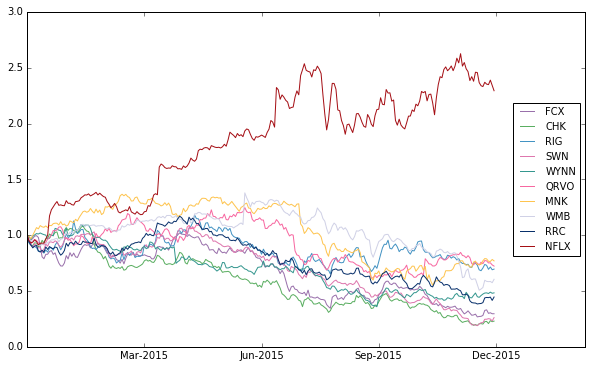

In [213]:
## create list of company ticker names that are in the top 10 most variable
columnlist = sdPriceChangeDFsortedfull[0:10].index.values.tolist()
##create data frame of price data for just the top 10 most variable companies
variablePriceData = stockPrices[columnlist]
##scale based on first price
variablePricesScaled = variablePriceData.divide(stockPrices[columnlist].ix[0])
y_pos_dates = np.arange(len(variablePricesScaled.index))
##Set colour scheme
colors = ['#9970ab','#5aae61','#4393c3','#de77ae','#35978f','#f768a1','#fec44f','#d0d1e6','#08306b','#a50f15']

x = np.linspace(0, 1, 10)
for i in range(0,len(columnlist)):
    plt.plot(y_pos_dates,variablePricesScaled[columnlist[i]], c=colors[i], label=columnlist[i].format(i=i))
plt.legend(loc='best')
plt.xticks([len(variablePricesScaled.index)/4,
            len(variablePricesScaled.index)*2/4,
            len(variablePricesScaled.index)*3/4,
            len(variablePricesScaled.index)],
           ["Mar-2015","Jun-2015","Sep-2015","Dec-2015"])
plt.legend(loc=5,prop={'size':10})
plt.show();

The **least volatile** companies for 2015 were the following:

In [171]:
sdPriceChangeDFsortedfull.tail(10)

,Standard Deviation,Name,Sector
PG,0.010086,Procter & Gamble,Consumer Staples
RSG,0.009953,Republic Services Inc,Industrials
VZ,0.009929,Verizon Communications,Telecommunications Services
T,0.009923,AT&T Inc,Telecommunications Services
DVA,0.009863,DaVita Inc.,Health Care
CLX,0.009706,The Clorox Company,Consumer Staples
PEP,0.009693,PepsiCo Inc.,Consumer Staples
AJG,0.009691,Arthur J. Gallagher & Co.,Financials
CHD,0.009579,Church & Dwight,Consumer Staples
KO,0.009045,The Coca Cola Company,Consumer Staples


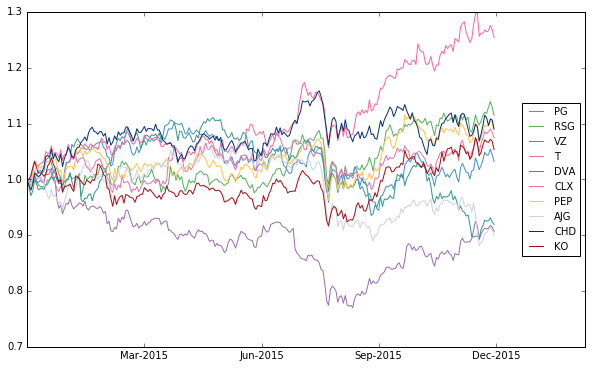

In [214]:
## create list of company ticker names that are in the top 10 most variable
columnlist = sdPriceChangeDFsortedfull[-10:].index.values.tolist()
##create data frame of price data for just the top 10 most variable companies
variablePriceData = stockPrices[columnlist]
##scale based on first price
variablePricesScaled = variablePriceData.divide(stockPrices[columnlist].ix[0])
y_pos_dates = np.arange(len(variablePricesScaled.index))
##Set colour scheme
colors = ['#9970ab','#5aae61','#4393c3','#de77ae','#35978f','#f768a1','#fec44f','#d0d1e6','#08306b','#a50f15']

x = np.linspace(0, 1, 10)
for i in range(0,len(columnlist)):
    plt.plot(y_pos_dates,variablePricesScaled[columnlist[i]], c=colors[i], label=columnlist[i].format(i=i))
plt.legend(loc='best')
plt.xticks([len(variablePricesScaled.index)/4,
            len(variablePricesScaled.index)*2/4,
            len(variablePricesScaled.index)*3/4,
            len(variablePricesScaled.index)],
           ["Mar-2015","Jun-2015","Sep-2015","Dec-2015"])
plt.legend(loc=5,prop={'size':10})
plt.show();

### 2. Correlations